# **Import Libraries and Data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
# make Google Drive is mounted in Colab:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Step 1: Prepare the data
# Load dataset
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/DATA Arima/Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# **DATA Cleaning**

In [5]:
#Data Cleaning
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Sales'] = df['Quantity']*df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [6]:
#Exclude December
df_f = df[df['InvoiceDate'] < '2011-12-01']

# **Exploratory Data Analysis**

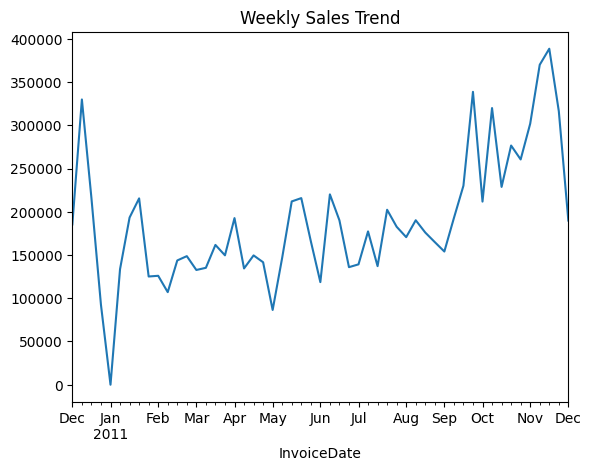

In [7]:
weekly_sales= df_f.set_index('InvoiceDate')['Sales'].resample('W').sum()
weekly_sales.plot(kind='line', title= 'Weekly Sales Trend')
plt.show()

/tmp/ipython-input-3540896899.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df_f.set_index('InvoiceDate') ['Sales'].resample('M').sum()


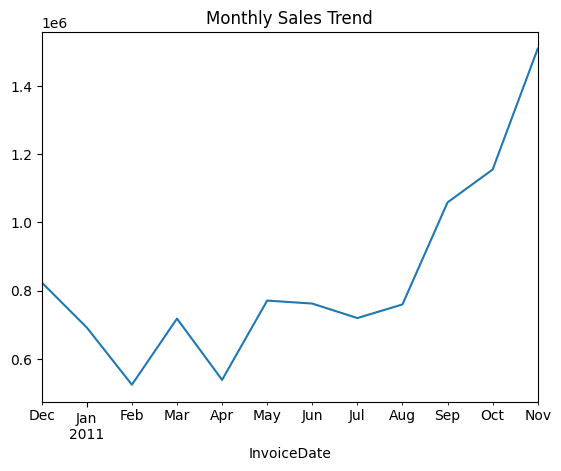

In [8]:
monthly_sales = df_f.set_index('InvoiceDate') ['Sales'].resample('M').sum()
monthly_sales.plot(kind='line', title= 'Monthly Sales Trend')
plt.show()

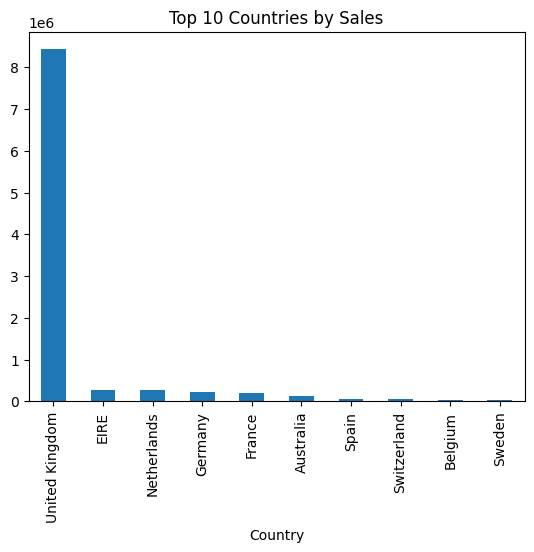

In [9]:
Top_Countries = df_f.groupby('Country')['Sales'].sum().sort_values(ascending=False).head(10)
Top_Countries.plot(kind='bar', title='Top 10 Countries by Sales')
plt.show()

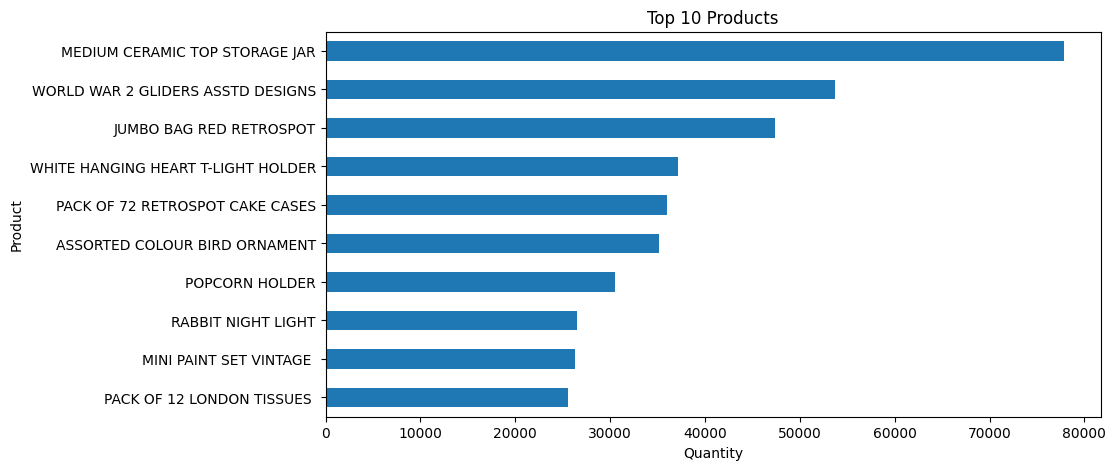

In [10]:
Top_Products = df_f.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
Top_Products.plot(kind='barh',figsize=(10,5),title='Top 10 Products')
plt.xlabel('Quantity')
plt.ylabel('Product')
plt.gca().invert_yaxis()
plt.show()

# **Choronological Split**

In [11]:
#Chronological Split
train = weekly_sales[:-10]
test = weekly_sales[-10:]

 # **Model fit : Double Exponential Smoothing**

In [12]:
# fit model
model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()

In [13]:
# Forecast and model
prediction = model.forecast(len(test))

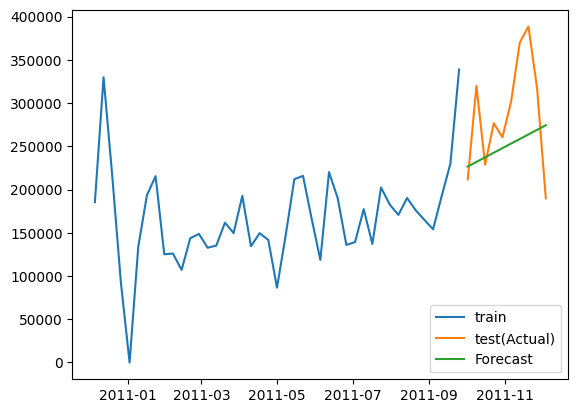

In [14]:
plt.plot(train, label = 'train')
plt.plot(test, label = 'test(Actual)')
plt.plot(prediction, label = 'Forecast')
plt.legend()
plt.show()

In [15]:
# Measure Model
Mae = mean_absolute_error(test, prediction)
Rmse = np.sqrt(mean_squared_error(test, prediction))

print(f"MAE: {Mae}")
print(f"RSME: {Rmse}")

MAE: 57499.30502098092
RSME: 70094.02819107054


 # **Model fit : Tripple Exponential Smoothing**

In [16]:
model2 = ExponentialSmoothing(train, trend= 'add', seasonal ='add', seasonal_periods= 4).fit()
prediction2 =model2.forecast(len(test))

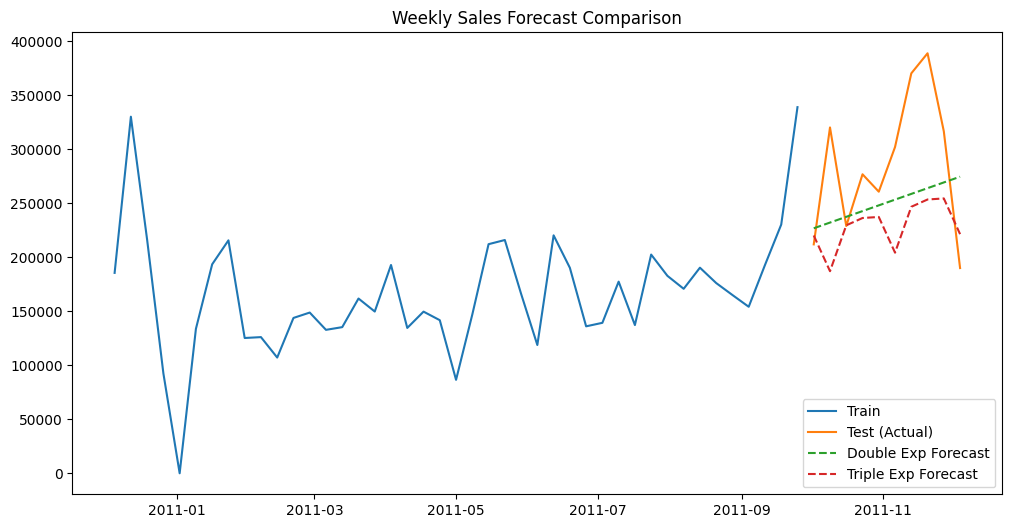

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test (Actual)')
plt.plot(prediction, label='Double Exp Forecast', linestyle='--')
plt.plot(prediction2, label='Triple Exp Forecast', linestyle='--')
plt.title('Weekly Sales Forecast Comparison')
plt.legend()
plt.show()

In [18]:
Mae = mean_absolute_error(test, prediction2)
Rmse = np.sqrt(mean_squared_error(test, prediction2))

In [19]:
print(f"MAE: {Mae}")
print(f"Rmse:{Rmse}")


MAE: 65575.87636999896
Rmse:82394.31153486138


 # **Model fit : ARIMA-Autoregressive integrated moving average**

In [20]:

!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 16.6 MB/s eta 0:00:00


In [21]:
import pmdarima as pm

In [22]:
# ১. CreateARIMA Model (use Auto-ARIMA to search best parameter)
arima_model = pm.auto_arima(train,
                            seasonal=False, # since less data
                            stepwise=True,
                            suppress_warnings=True,
                            error_action="ignore",
                            trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1162.676, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1073.742, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1135.757, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1076.174, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1077.724, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1079.131, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1061.893, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1066.693, Time=0.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1056.752, Time=0.44 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1057.589, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1058.348, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1063.041, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=1059.471, Time=0.38 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] i

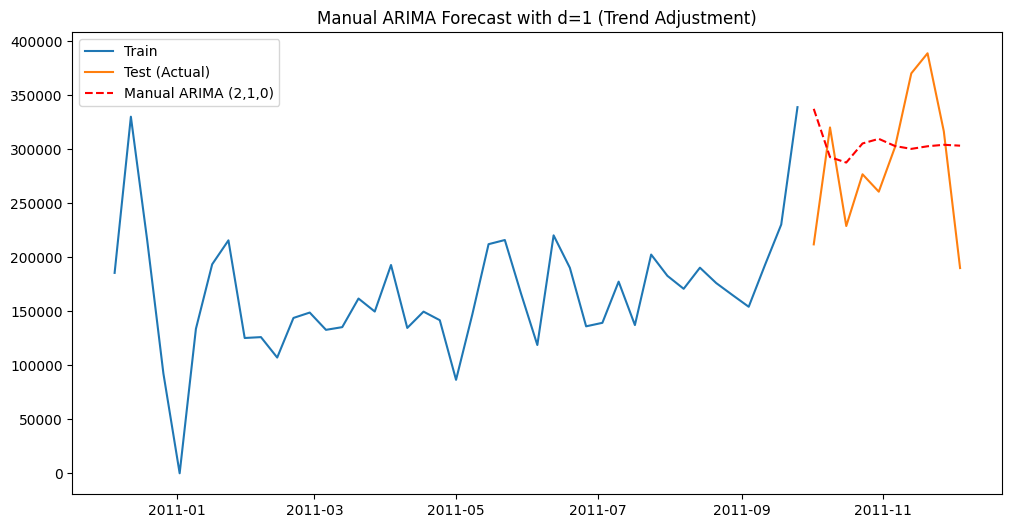

In [23]:
from statsmodels.tsa.arima.model import ARIMA

# ১. হাতে-কলমে d=1 সেট করে মডেল তৈরি (ARIMA 2,1,0)
# p=2 (আগের ২ সপ্তাহ), d=1 (১ বার ডিফারেন্সিং), q=0 (মুভিং এভারেজ ০)
manual_arima_model = ARIMA(train, order=(2, 1, 0))
manual_arima_result = manual_arima_model.fit()

# ২. ভবিষ্যৎবাণী বা ফোরকাস্ট করা
manual_arima_pred = manual_arima_result.forecast(steps=len(test))

# ৩. ভিজ্যুয়ালাইজেশন
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test (Actual)')
plt.plot(manual_arima_pred, label='Manual ARIMA (2,1,0)', color='red', linestyle='--')
plt.title('Manual ARIMA Forecast with d=1 (Trend Adjustment)')
plt.legend()
plt.show()



In [24]:
# ৪. এরর মেজারমেন্ট
mae = mean_absolute_error(test, manual_arima_pred)
Rmse = np.sqrt(mean_squared_error(test, manual_arima_pred))
print(f"Manual ARIMA MAE: {mae}")
print(f"Manual ARIMA RMSE: {Rmse}")

Manual ARIMA MAE: 57152.42557771036
Manual ARIMA RMSE: 69572.43408697323


 # **Forecast for next upcoming weeks**

In [25]:
future_steps = 4
future_forecast = manual_arima_result.forecast(steps=future_steps)

print("Next 4 Weeks Forecast:")
print(future_forecast)

# Total Sales target
print(f"Total Monthly Target: {future_forecast.sum()}")

Next 4 Weeks Forecast:
2011-10-02    337209.210631
2011-10-09    292533.144705
2011-10-16    287512.530920
2011-10-23    305168.089496
Freq: W-SUN, Name: predicted_mean, dtype: float64
Total Monthly Target: 1222422.9757520335
